In [1]:
# Imports
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

import datetime


#Settings
pd.set_option("display.max_rows", 70)
pd.set_option("display.max_columns", 101)

# Import of full_df 



In [2]:
full_df = pd.read_pickle('../data/processed/full_df.pkl')
full_df

,leg_no,fn_carrier,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration_x,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,Sched Groundtime,Act Groundtime,day_of_origin,ac_type,fn_number_y,ac_registration_y,mingt,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,flt_event_number,leg,route,rot_mismatch,actual_block_time,block_delay,ground_delay,day_of_week,hour_of_day_dep,hour_of_day_arr,minute_of_day_dep,Crewchange,act_groundtime_before,sched_groundtime_before,Crewchange_before,act_groundtime_new,sched_groundtime_new,rows_to_drop,rows_to_drop_grounddelay
9,272024970,East Carmen Airlines,2019-06-01,2019-06-01 03:25:00,2019-06-01,2019-06-01 06:45:00,2019-06-01 03:50:00,2019-06-01 07:01:00,ECLBAX,other problem,25.0,320,0,0,95.0,94.0,2019-06-01,321,EC3292,ECLBAX,45.0,New Jessica,East Carmen,South Nathaniel,2019-06-01 03:25:00,2019-06-01 06:45:00,2019-06-01 08:20:00,2019-06-01 10:35:00,95.0,272024970.0,272022230.0,27.0,NaN,25.0,1,New Jessica-East Carmen,East Carmen-New Jessica,False,191.0,-9.0,25.0,5,3,6,205,both,94.0,95.0,first flt of day,94.0,95.0,0,0
120,272022230,East Carmen Airlines,2019-06-01,2019-06-01 08:20:00,2019-06-01,2019-06-01 10:35:00,2019-06-01 08:35:00,2019-06-01 10:41:00,ECLBAX,other problem,15.0,320,60,60,75.0,120.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,2,East Carmen-South Nathaniel,East Carmen-South Nathaniel,False,126.0,-9.0,15.0,5,8,10,500,no change,94.0,95.0,both,120.0,75.0,0,0
198,272212848,East Carmen Airlines,2019-06-01,2019-06-01 11:50:00,2019-06-01,2019-06-01 14:15:00,2019-06-01 12:41:00,2019-06-01 14:52:00,ECLBAX,rotational problem,51.0,320,68,75,80.0,86.0,2019-06-01,321,EC3258,ECLBAX,45.0,South Nathaniel,East Carmen,Joneshaven,2019-06-01 11:50:00,2019-06-01 14:15:00,2019-06-01 15:35:00,2019-06-01 17:00:00,80.0,272212848.0,271997824.0,25.0,NaN,NaN,3,South Nathaniel-East Carmen,East Carmen-South Nathaniel,False,131.0,-14.0,51.0,5,11,14,710,both,120.0,75.0,no change,86.0,80.0,0,0
283,271997824,East Carmen Airlines,2019-06-01,2019-06-01 15:35:00,2019-06-01,2019-06-01 17:00:00,2019-06-01 16:18:00,2019-06-01 17:32:00,ECLBAX,rotational problem,43.0,320,64,70,50.0,32.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,4,East Carmen-Joneshaven,East Carmen-Joneshaven,False,74.0,-11.0,43.0,5,15,17,935,no change,86.0,80.0,both,32.0,50.0,0,0
317,271998033,East Carmen Airlines,2019-06-01,2019-06-01 17:50:00,2019-06-01,2019-06-01 19:10:00,2019-06-01 18:04:00,2019-06-01 19:14:00,ECLBAX,other problem,14.0,320,42,50,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,5,Joneshaven-East Carmen,East Carmen-Joneshaven,False,70.0,-10.0,14.0,5,17,19,1070,last flt of day,32.0,50.0,no change,NaN,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11856,272211046,East Carmen Airlines,2019-06-30,2019-06-30 10:30:00,2019-06-30,2019-06-30 12:10:00,2019-06-30 10:34:00,2019-06-30 12:05:00,ECLXEX,other problem,4.0,320,37,45,50.0,85.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,3,Lisamouth-East Carmen,East Carmen-Lisamouth,False,91.0,-9.0,4.0,6,10,12,630,both,39.0,45.0,no change,85.0,50.0,0,0
11916,271969272,East Carmen Airlines,2019-06-30,2019-06-30 13:00:00,2019-06-30,2019-06-30 14:15:00,2019-06-30 13:30:00,2019-06-30 14:36:00,ECLXEX,rotational problem,30.0,320,0,0,45.0,54.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,4,East Carmen-West Jason,East Carmen-West Jason,False,66.0,-9.0,30.0,6,13,14,780,no change,85.0,50.0,both,54.0,45.0,0,0
11959,271969452,East Carmen Airlines,2019-06-30,2019-06-

<AxesSubplot:>

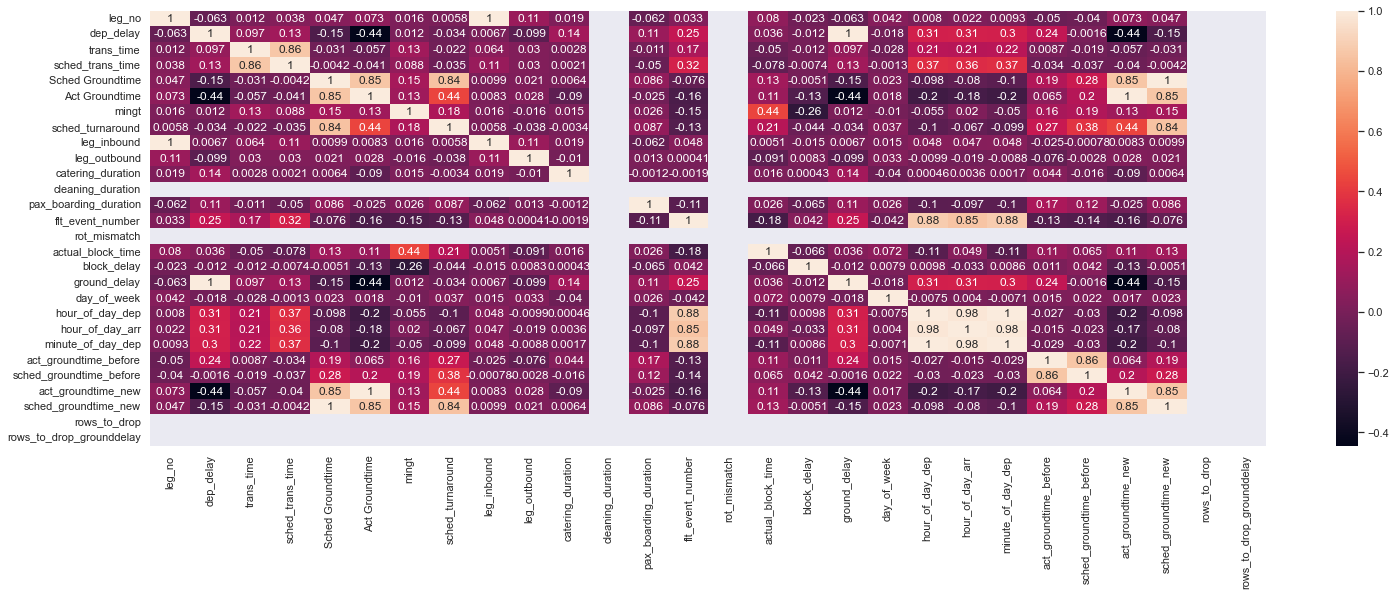

In [7]:
# Correlation Matrix
sns.set(rc={'figure.figsize':(25, 8)})
corr_ground = full_df[full_df['rows_to_drop_grounddelay']==0].corr()
sns.heatmap(corr_ground, annot=True)

In [4]:
full_df[full_df['sched_turnaround'] != full_df['Sched Groundtime']].dropna( subset = ['Sched Groundtime', 'sched_turnaround'])

,leg_no,fn_carrier,fn_number_x,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration_x,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,Sched Groundtime,Act Groundtime,day_of_origin,ac_type,fn_number_y,ac_registration_y,mingt,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,flt_event_number,rot_mismatch,actual_block_time,block_delay,ground_delay,day_of_week,hour_of_day_dep,hour_of_day_arr,minute_of_day_dep,Crewchange,act_groundtime_before,sched_groundtime_before,Crewchange_before,act_groundtime_new,sched_groundtime_new,rows_to_drop,rows_to_drop_grounddelay
2982,272015977,East Carmen Airlines,EC3220,Erichaven,East Carmen,2019-06-08,2019-06-08 10:30:00,2019-06-08,2019-06-08 12:25:00,2019-06-08 10:46:00,2019-06-08 12:26:00,ECLBSX,other problem,16.0,320,11,45,360.0,378.0,2019-06-08,320,EC3220,ECLBSX,40.0,Erichaven,East Carmen,NaN,2019-06-08 10:30:00,2019-06-08 12:25:00,2019-06-08 13:15:00,2019-06-08 14:00:00,50.0,272015977.0,272352651.0,28.0,NaN,NaN,3,False,100.0,1.0,16.0,5,10,12,630,both,46.0,45.0,no change,378.0,360.0,0,0
3326,272100521,East Carmen Airlines,EC11460,Richardsonburgh,East Carmen,2019-06-09,2019-06-09 08:15:00,2019-06-09,2019-06-09 10:55:00,2019-06-09 08:43:00,2019-06-09 11:15:00,ECLBTX,other problem,28.0,320,44,45,430.0,429.0,2019-06-09,320,EC11460,ECLBTX,40.0,Richardsonburgh,East Carmen,NaN,2019-06-09 08:15:00,2019-06-09 10:55:00,2019-06-09 12:00:00,2019-06-09 12:45:00,65.0,272100521.0,272352652.0,21.0,NaN,NaN,2,False,152.0,20.0,28.0,6,8,10,495,both,53.0,45.0,no change,429.0,430.0,0,0
1214,271961157,East Carmen Airlines,EC2614,Yoderburgh,East Carmen,2019-06-04,2019-06-04 05:00:00,2019-06-04,2019-06-04 06:35:00,2019-06-04 05:13:00,2019-06-04 06:45:00,ECLDGX,other problem,13.0,320,0,0,400.0,471.0,2019-06-04,319,EC2614,ECLDGX,40.0,Yoderburgh,East Carmen,NaN,2019-06-04 05:00:00,2019-06-04 06:35:00,2019-06-04 07:40:00,2019-06-04 08:25:00,65.0,271961157.0,272352650.0,26.0,NaN,NaN,1,False,92.0,10.0,13.0,1,5,6,300,both,471.0,400.0,first flt of day,471.0,400.0,0,0
7499,272210730,East Carmen Airlines,EC3230,Haynesside,East Carmen,2019-06-19,2019-06-19 13:05:00,2019-06-19,2019-06-19 14:20:00,2019-06-19 13:05:00,2019-06-19 14:17:00,ECLGOX,no reason,0.0,DH4,23,55,235.0,249.0,2019-06-19,DHX,EC3230,ECLGOX,35.0,Haynesside,East Carmen,East Carmen,2019-06-19 13:05:00,2019-06-19 14:20:00,2019-06-19 15:20:00,2019-06-19 16:05:00,60.0,272210730.0,272012153.0,23.0,NaN,17.0,5,False,72.0,-3.0,0.0,2,13,14,785,cockpit,30.0,55.0,no change,249.0,235.0,0,0
8667,272229279,East Carmen Airlines,EC2836,Davidtown,East Carmen,2019-06-22,2019-06-22 12:00:00,2019-06-22,2019-06-22 13:55:00,2019-06-22 12:10:00,2019-06-22 13:53:00,ECLWPX,other problem,10.0,E95,69,80,285.0,300.0,2019-06-22,E95,EC2836,ECLWPX,40.0,Davidtown,East Carmen,NaN,2019-06-22 12:00:00,2019-06-22 13:55:00,2019-06-22 14:35:00,2019-06-22 15:40:00,40.0,272229279.0,272350803.0,22.0,NaN,NaN,4,False,103.0,-2.0,10.0,5,12,13,720,both,70.0,80.0,no change,300.0,285.0,0,0


In [5]:
corr_ground['ground_delay'].sort_values()

act_groundtime_new         -0.443603
Act Groundtime             -0.442369
sched_groundtime_new       -0.145482
Sched Groundtime           -0.145482
leg_outbound               -0.098638
leg_no                     -0.062617
sched_turnaround           -0.033690
day_of_week                -0.018088
sched_groundtime_before    -0.001589
leg_inbound                 0.006671
mingt                       0.012151
actual_block_time           0.036107
trans_time                  0.097022
pax_boarding_duration       0.112565
sched_trans_time            0.133466
catering_duration           0.142523
act_groundtime_before       0.244253
flt_event_number            0.251420
minute_of_day_dep           0.303935
hour_of_day_dep             0.306368
hour_of_day_arr             0.308311
block_delay                 0.961078
ground_delay                1.000000
dep_delay                   1.000000
cleaning_duration                NaN
rot_mismatch                     NaN
rows_to_drop                     NaN
r

Hypothesis 4: Time of day has influence on dep delay

<AxesSubplot:xlabel='Min_of_Day', ylabel='ground_delay'>

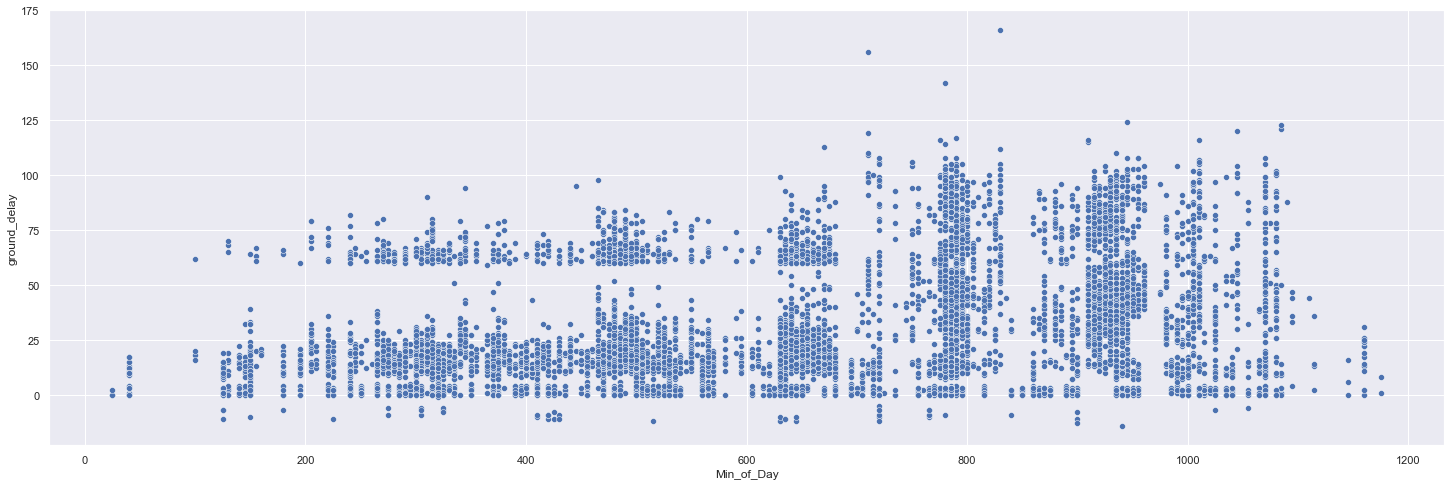

In [6]:
temp = full_df[full_df['rows_to_drop_grounddelay']==0][['dep_sched_time', 'ground_delay']]

temp['Min_of_Day'] = temp['dep_sched_time'].dt.hour*60 + temp['dep_sched_time'].dt.minute


sns.set(rc={'figure.figsize':(25, 8)})
sns.scatterplot(x=temp['Min_of_Day'], y=temp['ground_delay'])


<AxesSubplot:>

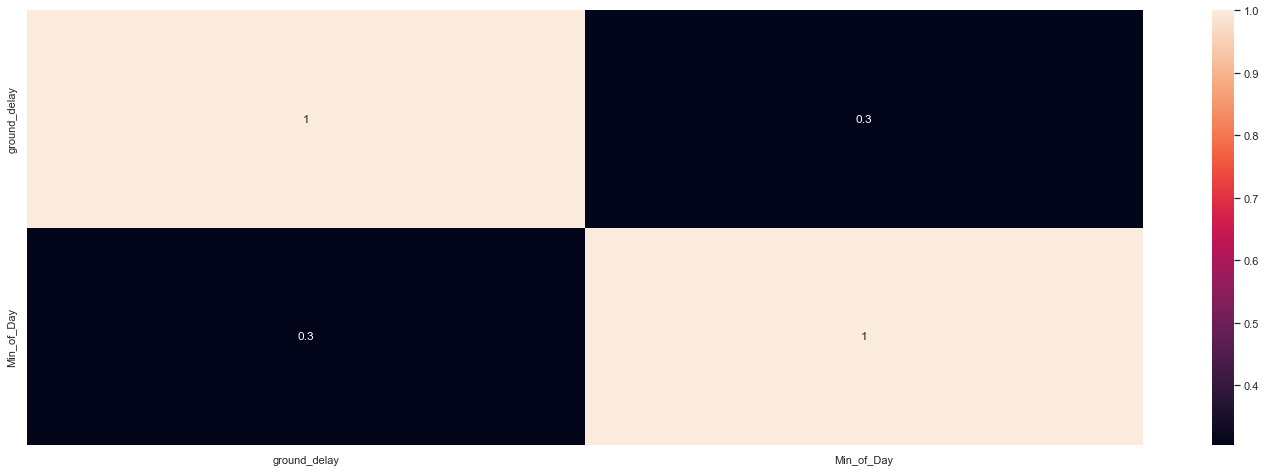

In [7]:
sns.heatmap(temp.corr(), annot = True)